In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn

import os
import sys

import tensorflow as tf

from sklearn.metrics import mean_squared_error

from dipy.tracking.streamline import Streamlines,cluster_confidence
from dipy.tracking.distances import bundles_distances_mdf
from dipy.tracking.streamlinespeed import (compress_streamlines, length,
                                           set_number_of_points)

print(tf.__version__)
print(sys.version_info)

    
sys.path.append(r'toolkit')

from visualize_score import  visualize_streamline, visualize_streamline_removed

2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)


D:\anaconda3\envs\tensorflow\lib\site-packages\setuptools\distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


In [15]:
def cal_precision(mse,label):
    # precision, recall, F1 score for nomal fiber detection 
    mini = np.percentile(mse,0.5)
    maxi = np.percentile(mse,99.5)
    mse_log = mse
    Prec =[]
    Recall = []
    F1=[]
    X = np.linspace(start = mini, stop = maxi, num = 500)
    X = X[1:]
    for x in X:
        thre = x
        pred = 1*(mse_log<thre)
        truth_val = 1
        TP = np.sum((pred==truth_val) * (label==truth_val))
        FP = np.sum((pred==1) * (label==0))
        FN = np.sum((pred==0) * (label==1))
        precision = TP / (TP+FP)
        recall = TP / (TP+FN)
        F1_tmp = 2*(precision*recall)/(precision+recall)
        
        Prec.append(precision)
        Recall.append(recall)
        F1.append(F1_tmp)
    return X,Prec,Recall,F1

def cal_precision_reverse(mse,label):
    # precision, recall, F1 score for anomalous fiber detection 
    mini = np.percentile(mse,0.5)
    maxi = np.percentile(mse,99.5)    
    mse_log = mse
    Prec =[]
    Recall = []
    F1=[]
    X = np.linspace(start = mini, stop = maxi, num = 500)
    X = X[1:]
    for x in X:
        thre = x
        pred = 1*(mse_log<thre)

        TP = np.sum((pred==0) * (label==0))
        FP = np.sum((pred==0) * (label==1))
        FN = np.sum((pred==1) * (label==0))
        precision = TP / (TP+FP)
        recall = TP / (TP+FN)
        F1_tmp = 2*(precision*recall)/(precision+recall)
        
        Prec.append(precision)
        Recall.append(recall)
        F1.append(F1_tmp)
    return X,Prec,Recall,F1

In [16]:
folder = 'data_4_model_new'
test_list = np.load(os.path.join(folder, 'test_list.npy'),'r')



models = ['srnn_oup_mse','srnn2_oup_mse','srnn2_dr_oup_mse','srnn_bi_oup_mse','LSTM_oup_mse','LSTM_dr_oup_mse','LSTM_bi_oup_mse'
          ,'GRU_oup_mse','GRU_dr_oup_mse','GRU_bi_oup_mse','seq2seq_oup_mse','seq2seq_attention_oup_mse','GRU_deep_oup_mse',
          'LSTM_deep_oup_mse','deep_bi_LSTM_50_oup_mse','deep_bi_GRU_50_oup_mse',
          'RNN_deep_oup_mse','nn_oup_mse','50full_seq2seq_attention_200_60oup_mse',
         '20full_seq2seq_150_60oup_mse','20full_seq2seq-sf-simple_64_60oup_mse']


titles = ['simple RNN','Autoencoder RNN','Undercomplete RNN','Bidirectional RNN','Autoencoder LSTM','Undercomplete LSTM','Bidirectional LSTM',
          'Autoencoder GRU','Undercomplete GRU','Bidirectional GRU','Seq2seq','Seq2seq + Attention','deep GRU','deep LSTM',
          'Bi LSTM deep','Bi GRU deep','deep RNN','fully connected autoencoder',
          'New seq2seq+attention','New seq2seq','New ensemble seq2seq']

manual_label_dict = np.load(os.path.join('toolkit','manual_label_dict_84.npy'),allow_pickle = True).item()


In [17]:
for i in range(len(titles)):
    print('index:{}       model:{}'.format(i,titles[i]))

index:0       model:simple RNN
index:1       model:Autoencoder RNN
index:2       model:Undercomplete RNN
index:3       model:Bidirectional RNN
index:4       model:Autoencoder LSTM
index:5       model:Undercomplete LSTM
index:6       model:Bidirectional LSTM
index:7       model:Autoencoder GRU
index:8       model:Undercomplete GRU
index:9       model:Bidirectional GRU
index:10       model:Seq2seq
index:11       model:Seq2seq + Attention
index:12       model:deep GRU
index:13       model:deep LSTM
index:14       model:Bi LSTM deep
index:15       model:Bi GRU deep
index:16       model:deep RNN
index:17       model:fully connected autoencoder
index:18       model:New seq2seq+attention
index:19       model:New seq2seq
index:20       model:New ensemble seq2seq


# ↓ type in the model index you would like to see

In [19]:
model_list = [1,2,3,4,5]

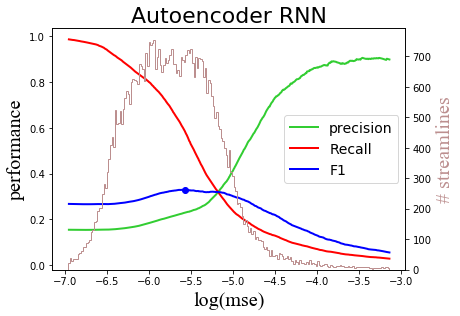

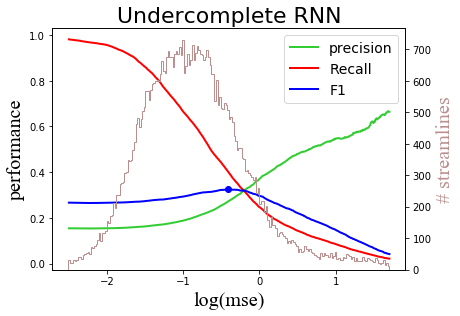

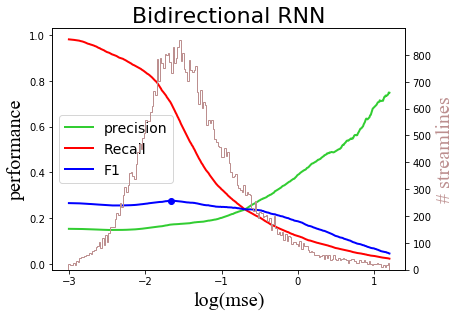

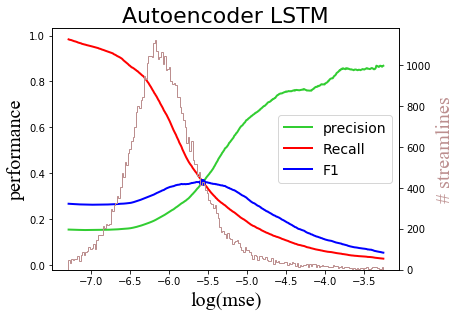

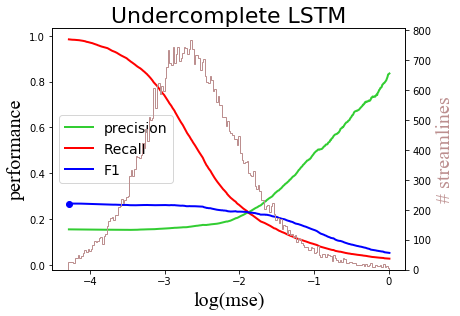

In [20]:
for tmp in model_list:
    index = tmp
    model = models[index]
    filename = model+'.npy'
    mse_all = np.load(os.path.join(folder, filename),allow_pickle=True)
            
    mse =[]
    label = []
    for i, subj in enumerate(test_list):
        subj = os.path.splitext(subj)[0]
        mse_tmp = np.array(mse_all[i])
        mse = np.concatenate((mse,mse_tmp), axis=None)
        
        label_tmp = manual_label_dict[subj]
        label = np.concatenate((label,label_tmp))
        
    mse_log = np.log(mse)
    
    
    #X,Prec,Recall,F1 = cal_precision(mse_log,label)
    X,Prec,Recall,F1 = cal_precision_reverse(mse_log,label)
    
    
    color2 = 'rosybrown'
    font1 = {'family': 'Times New Roman',
             'weight': 'normal',
             'size': 20,
             'color' :color2,
             }
    
    font2 = {'family': 'Times New Roman',
             'weight': 'normal',
             'size': 20,
             }
    
    maxindex  = np.argmax(F1)
    
    fig, ax1 = plt.subplots(1,figsize=(6.5, 4.5))
    #ax1.axvline(x=X[maxindex], color="r", linestyle="--")
    ax1.set_xlabel("log(mse)", font2)
    ax1.set_ylabel("performance", font2)
    
    ax1.plot(X, Prec, color="limegreen", linestyle="-", linewidth=2, label='precision')
    
    ax1.plot(X, Recall, color="r", linestyle="-", linewidth=2, label='Recall')
    ax1.plot(X, F1, color="b", linestyle="-", linewidth=2, label='F1')
    #ax1.scatter([X[maxindex],F1[maxindex]])
    ax1.plot(X[maxindex], F1[maxindex], 'o', color='b')
    ax1.legend(fontsize=14)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    mini = np.percentile(mse_log,0.5)
    maxi = np.percentile(mse_log,99.5)
    ax2.set_ylabel('# streamlines',  font1)  # we already handled the x-label with ax1
    ax2.hist(mse_log, range=(mini,maxi),color=color2,label='MSE',bins=200,histtype='step')
    
    plt.title(titles[index],fontsize=22) 
    fig.tight_layout()  # otherwise the right y-label is slightly clipped


In [24]:
def draw_capacity_reverse(index_list):
    fig, ax1 = plt.subplots(1,figsize=(9.5, 4.5))
    ax1.set_ylabel("F1 score", font2)
    ax1.set_xlabel("increasement of threshold", font2)
    colors = ['tab:blue', 'tab:orange', 'tab:green','tab:red', 'tab:purple',
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive','k', 'tab:cyan'
              ]
    for j in range(len(index_list)) :
        index = index_list[j]
        model = models[index]
        filename = model+'.npy'
        mse_all = np.load(os.path.join(folder, filename),allow_pickle=True)
        
        mse =[]
        label = []
        for i, subj in enumerate(test_list):
            subj = os.path.splitext(subj)[0]
            mse_tmp = np.array(mse_all[i])
            mse = np.concatenate((mse,mse_tmp), axis=None)
            
            label_tmp = manual_label_dict[subj]
            label = np.concatenate((label,label_tmp))
                
        X,Prec,Recall,F1 = cal_precision_reverse(np.log(mse),label)
        maxindex  = np.argmax(F1)
        
        ax1.plot(F1,  linestyle="-", linewidth=1.5, label=titles[index], color = colors[j])
        ax1.plot(maxindex, F1[maxindex], 'o' , color = colors[j])

    ax1.legend(fontsize=12)



# ↓ type in the model index you would like to see
len(mosel_list) <=10 since we only set 10 colors

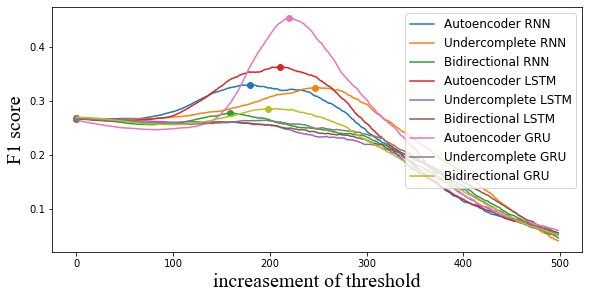

In [26]:
model_list_2 = [1,2,3,4,5,6,7,8,9]
draw_capacity_reverse(model_list_2)

## performace of the seq2seq model with different ratio (# of units)/(# of vertex each curve)

In [29]:
a1 = np.array([48.6542,0.3919,0.0942,0.0422,0.0275,0.0215,0.0188,0.0165,0.0156,0.0145])
a2 = np.array([85.5962,1.2836,0.2384,0.087,0.0452,0.0309,0.0252,0.0216,0.0192,0.0179])
a3 = np.array([176.1449,12.1776,1.7448,0.4632,0.1756,0.087,0.0538,0.0397,0.0328,0.0285])
a4 = np.array([287.9242,71.1549,16.8024,4.31,1.3496,0.4985,0.223,0.1267,0.0828,0.0633])
a5 = np.array([458.2345,246.703,143.5471,79.0492,40.7052,20.0137,9.5273,4.5066,2.1643,1.1026])
a6 = np.array([561.8597,402.1477,304.0802,229.8315,166.9006,118.7631,82.9395,56.4797,37.4279,24.187])


b1 = np.array([44.44513761,43.14013042,41.40971444,32.52193832,30.02624222,38.0437223,28.09470598,30.18382839,30.57290732,30.57290732])
b2 = np.array([85.75852376,53.07129401,64.94907644,44.47601594,47.1685528,40.35555423,46.08528974,52.26201163,39.68145343,28.6418161])
b3 = np.array([178.7504939,177.6441533,175.0257048,139.2651297,116.8780985,89.24768643,80.22883086,85.23849386,52.1415565,73.58099803])
b4 = np.array([210.8702817,193.6723953,305.4911478,277.1294872,245.0754638,202.8125357,123.1059995,145.4929123,104.5260564,95.37398897])
b5 = np.array([360.2253266,249.6273919,220.0757499,246.5233236,260.9898367,215.2440912,196.6306458,232.5705864,264.6525497,272.2453901])
b6 = np.array([496.6084459,374.5256896,303.6002108,258.6171027,242.7336629,238.3555754,241.1729966,242.3769479,222.288869,200.3586256])

colors = ['tab:blue', 'tab:orange', 'tab:green','tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive','k', 'tab:cyan']

Text(0.5, 1.0, 'validate error with different ratio')

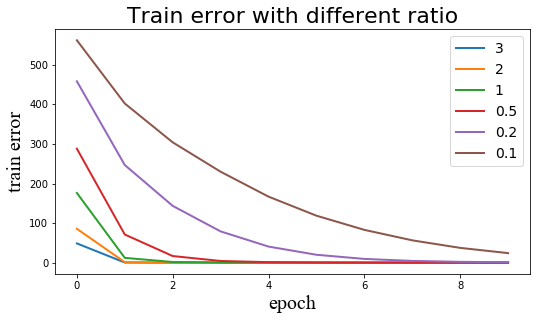

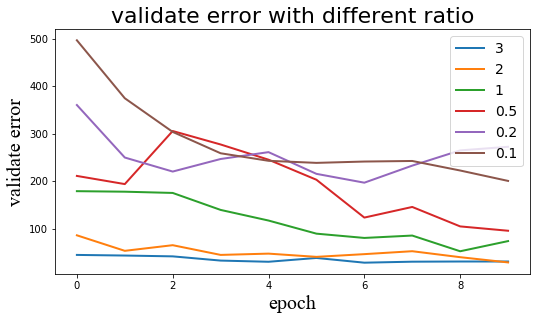

In [31]:
fig, ax1 = plt.subplots(1,figsize=(8.5, 4.5))
#ax1.axvline(x=X[maxindex], color="r", linestyle="--")
ax1.set_xlabel("epoch", font2)
ax1.set_ylabel("train error", font2)

ax1.plot(a1, color=colors[0], linestyle="-", linewidth=2, label='3')
ax1.plot(a2, color=colors[1], linestyle="-", linewidth=2, label='2')
ax1.plot(a3, color=colors[2], linestyle="-", linewidth=2, label='1')
ax1.plot(a4, color=colors[3], linestyle="-", linewidth=2, label='0.5')
ax1.plot(a5, color=colors[4], linestyle="-", linewidth=2, label='0.2')
ax1.plot(a6, color=colors[5], linestyle="-", linewidth=2, label='0.1')
ax1.legend(fontsize=14)
plt.title('Train error with different ratio',fontsize=22) 
#%%
fig, ax1 = plt.subplots(1,figsize=(8.5, 4.5))
#ax1.axvline(x=X[maxindex], color="r", linestyle="--")
ax1.set_xlabel("epoch", font2)
ax1.set_ylabel("validate error", font2)

ax1.plot(b1, color=colors[0], linestyle="-", linewidth=2, label='3')
ax1.plot(b2, color=colors[1], linestyle="-", linewidth=2, label='2')
ax1.plot(b3, color=colors[2], linestyle="-", linewidth=2, label='1')
ax1.plot(b4, color=colors[3], linestyle="-", linewidth=2, label='0.5')
ax1.plot(b5, color=colors[4], linestyle="-", linewidth=2, label='0.2')
ax1.plot(b6, color=colors[5], linestyle="-", linewidth=2, label='0.1')
ax1.legend(fontsize=14)
plt.title('validate error with different ratio',fontsize=22) 